# <center>CITS5508 Lab sheet 3: E Coli & Concrete Slump</center>
**Name: Wei Yang**<br>
**Student number: 21220208**<br>
**Date created:  24th March 2021**<br>
**Last modified: 31th March 2021**<br>

## 1. Introduction
This lab sheet consists of two projects. The first part is to train two decision tree classifiers and compare their performance. The second is to train and test two decision tree
regressor and a support vector regressor. 

In [1]:
#libray imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix,classification_report
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR


## 2.Project 1
The first project asks you to train two decision tree classifiers and compare their performance.
### 2.1 Loading data

In [2]:
#loading data with column names
columns=['Seq_Name','mcg','gvh','lip','chg','aac','alm1','alm2','loc_site']
df1 = pd.read_csv("ecoli.data", sep='\s+', names=columns)

### 2.2 Data visualisation and cleaning
#### 2.2.1 Visulisation

In [3]:
#show the frist few row of the dataframe
df1.head()

,Seq_Name,mcg,gvh,lip,chg,aac,alm1,alm2,loc_site
0,AAT_ECOLI,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp
1,ACEA_ECOLI,0.07,0.40,0.48,0.5,0.54,0.35,0.44,cp
2,ACEK_ECOLI,0.56,0.40,0.48,0.5,0.49,0.37,0.46,cp
3,ACKA_ECOLI,0.59,0.49,0.48,0.5,0.52,0.45,0.36,cp
4,ADI_ECOLI,0.23,0.32,0.48,0.5,0.55,0.25,0.35,cp


In [4]:
#It can be seen that there are 336 instance and 9 columns(1 lable and 8 features)
#loc_site is our label. 7 features are numerical and 1 is catagorical
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Seq_Name  336 non-null    object 
 1   mcg       336 non-null    float64
 2   gvh       336 non-null    float64
 3   lip       336 non-null    float64
 4   chg       336 non-null    float64
 5   aac       336 non-null    float64
 6   alm1      336 non-null    float64
 7   alm2      336 non-null    float64
 8   loc_site  336 non-null    object 
dtypes: float64(7), object(2)
memory usage: 23.8+ KB


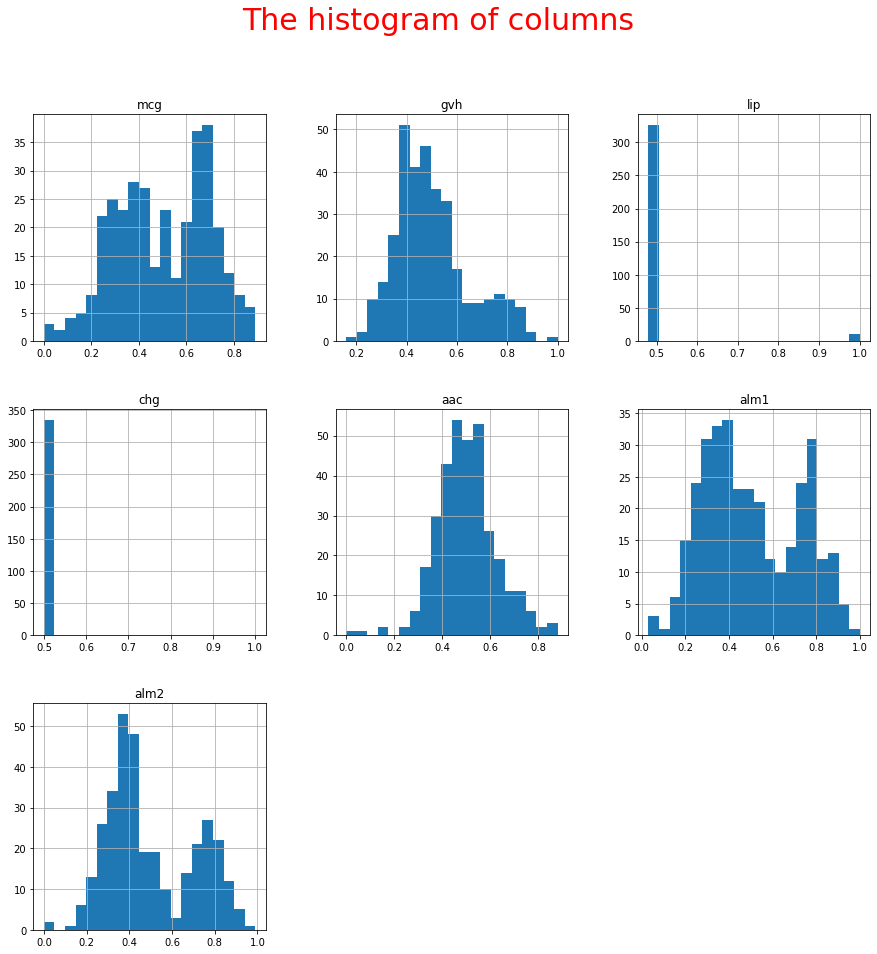

In [5]:
#plot the histogram of each column so as to display different features
df1.hist(bins=20, figsize=(15,15))
plt.suptitle("The histogram of columns",fontsize=30, color = 'red')
plt.show()

#### 2.1.2 Data Cleaning
- We need to remove the rows belonging to classes having less than 10 instances as it is not possible to classify them. 
- It also can be seen that values of Seq_Name are unique, so it is useless in the classification model.

In [6]:
#find out which class have less than 10 instance
df1["loc_site"].value_counts()<10

cp     False
im     False
pp     False
imU    False
om     False
omL     True
imL     True
imS     True
Name: loc_site, dtype: bool

In [7]:
#investigation the distribution of the categorical features
df1["Seq_Name"].value_counts()

KGTP_ECOLI    1
MURF_ECOLI    1
CYDB_ECOLI    1
TONB_ECOLI    1
TESA_ECOLI    1
             ..
CYPC_ECOLI    1
SYP_ECOLI     1
DDLB_ECOLI    1
DMSC_ECOLI    1
NLPE_ECOLI    1
Name: Seq_Name, Length: 336, dtype: int64

In [8]:
#define a function to remove rows in classes that have less than 10 instances and the categorical features
#Also split the data into label and features
def clean_ecoli(df, drop_labels=[]):
    df_deleted = df.drop(columns=["Seq_Name"], axis=1)
    for i in drop_labels:
        df_deleted = df_deleted[df_deleted.loc_site != i]
        df_deleted.reset_index()
    X_unscaled = df_deleted.drop(columns=["loc_site"], axis=1)
    y = df_deleted["loc_site"]
    return X_unscaled,y

In [9]:
#Get the unscaled features and label for fitting the model
drop_labels=['omL','imL','imS']
X_clf_unscaled,y_clf = clean_ecoli(df1,drop_labels)

### 2.2 Unscaled Decision Tree classifiers
**The hyperparameters chosen for Grid search:**<br>
- **criterion:**  : gini or entropy, two different measures of measuring purity of a classified class.
- **max_depth:**  Maximum depth of the Decision Tree. Reducing max_depth will regularize the model and thus reduce the risk of overfitting and vice versa. The values I choose are 2,5,8.
- **min_samples_leaf:** the minimum number of samples a leaf node must have. Too small can cause overfitting and vice versa. The values I choose are 1,10,20.

In [10]:
#criterion, max depth and min samples leaf are selected hyperparameters. 
# 2-3 values for each hyperparamenter are investgated 
param_grid = [{
    'criterion': ["gini", "entropy"],
    'max_depth': [2, 5, 8],
    'min_samples_leaf': [1, 10, 20]   
}]

In [11]:
#Grid search with 3-fold cross validation on three hyperparameters
tree_clf_unscaled = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=3, scoring="f1_weighted", return_train_score=True)

In [12]:
#Train and cross validate the model with raw data to find the best hyperparameter
tree_clf_unscaled.fit(X_clf_unscaled,y_clf)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [2, 5, 8],
                          'min_samples_leaf': [1, 10, 20]}],
             return_train_score=True, scoring='f1_weighted')

### 2.3 Scaled Decision Tree classifiers
I use the same grid search parameter options to do this part

In [13]:
#Using Standard Scaler to do scaling
scaler = StandardScaler()
#Perform an appropriate feature scaling set 
X_clf_scaled = scaler.fit_transform(X_clf_unscaled) #fit the Scaler with training set to find parameters then make a transformation on train set

In [14]:
#Grid search with 3-fold cross validation on three hyperparameters
tree_clf_scaled = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=3, scoring="f1_weighted", return_train_score=True)

In [15]:
#Train and cross validate the model with scaled data to find the best hyperparameter
tree_clf_scaled.fit(X_clf_scaled,y_clf)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [2, 5, 8],
                          'min_samples_leaf': [1, 10, 20]}],
             return_train_score=True, scoring='f1_weighted')

### 2.4 F1 score and confusion matrix comparison  
#### 2.4.1 Best parameters comparison 
**Regardless of scaling, the best parameters are the same.**

In [16]:
print("Best parameters for both model:")
print(f"Unscaled tree: {tree_clf_unscaled.best_params_}")
print(f"Scaled tree: {tree_clf_scaled.best_params_}")

Best parameters for both model:
Unscaled tree: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10}
Scaled tree: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10}


#### 2.4.2 F1 score comparison 
**Regardless of scaling, F1 score are the same for both model.**

In [17]:
print(f"F1 score for unscaled tree:{tree_clf_unscaled.best_estimator_.score(X_clf_unscaled, y_clf)}")
print(f"F1 score for scaled tree:{tree_clf_scaled.best_estimator_.score(X_clf_scaled, y_clf)}")

F1 score for unscaled tree:0.8899082568807339
F1 score for scaled tree:0.8899082568807339


#### 2.4.3 Confusion matrix comparison 
**Regardless of scaling, the confusion matrix are the same for both model.**

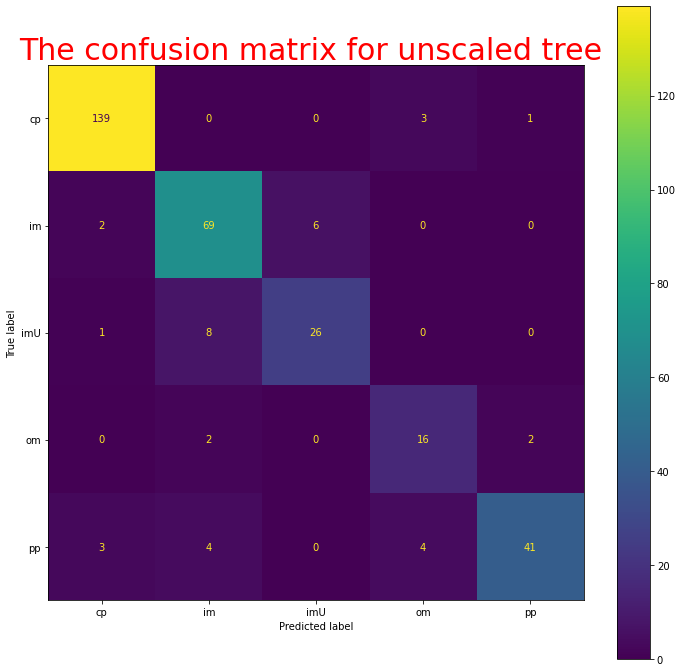

In [18]:
# Confusion matrix illustration 
fig, ax = plt.subplots(figsize=(12, 12)) #set the size of the figure
plot_confusion_matrix(tree_clf_unscaled,X_clf_unscaled,y_clf, ax=ax)
plt.title("The confusion matrix for unscaled tree ",fontsize=30, color = 'red')
plt.show()

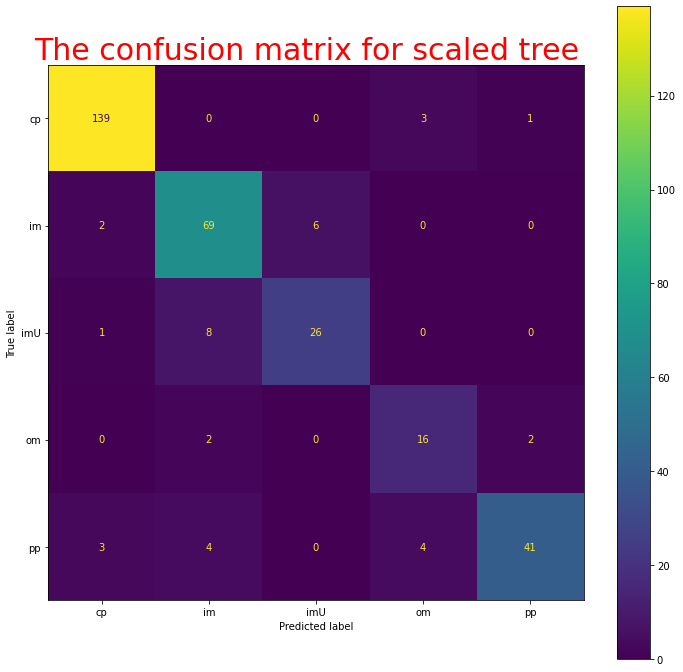

In [19]:
# Confusion matrix illustration 
from sklearn.metrics import plot_confusion_matrix,classification_report
fig, ax = plt.subplots(figsize=(12, 12)) #set the size of the figure
plot_confusion_matrix(tree_clf_scaled,X_clf_scaled,y_clf, ax=ax)
plt.title("The confusion matrix for scaled tree  ",fontsize=30, color = 'red')
plt.show()

#### 2.4.4 Conclusion
The best hyperparameter for both model are:
- 'criterion'=  'gini', 
- 'max_depth'=  5, 
- 'min_samples_leaf'=  10<br>

The f1 score and confusion matrix are exactly the same for both model.

**The result of Decision tree classifiers is not affected by the scaling.**

## 3.Project 2
In this project, we will try to use the 7 input columns to predict the last output column (Compressive Strength (28-day)(Mpa)).
### 3.1 Loading data

In [20]:
#load data and show the frist few row of the dataframe
df2 = pd.read_csv("slump_test.data", sep=',')

### 3.2 Data visualisation and cleaning
#### 3.2.1 Data visualisation

In [21]:
#show the frist few row of the dataframe
df2.head()

,No,Cement,Slag,Fly ash,Water,SP,Coarse Aggr.,Fine Aggr.,SLUMP(cm),FLOW(cm),Compressive Strength (28-day)(Mpa)
0,1,273.0,82.0,105.0,210.0,9.0,904.0,680.0,23.0,62.0,34.99
1,2,163.0,149.0,191.0,180.0,12.0,843.0,746.0,0.0,20.0,41.14
2,3,162.0,148.0,191.0,179.0,16.0,840.0,743.0,1.0,20.0,41.81
3,4,162.0,148.0,190.0,179.0,19.0,838.0,741.0,3.0,21.5,42.08
4,5,154.0,112.0,144.0,220.0,10.0,923.0,658.0,20.0,64.0,26.82


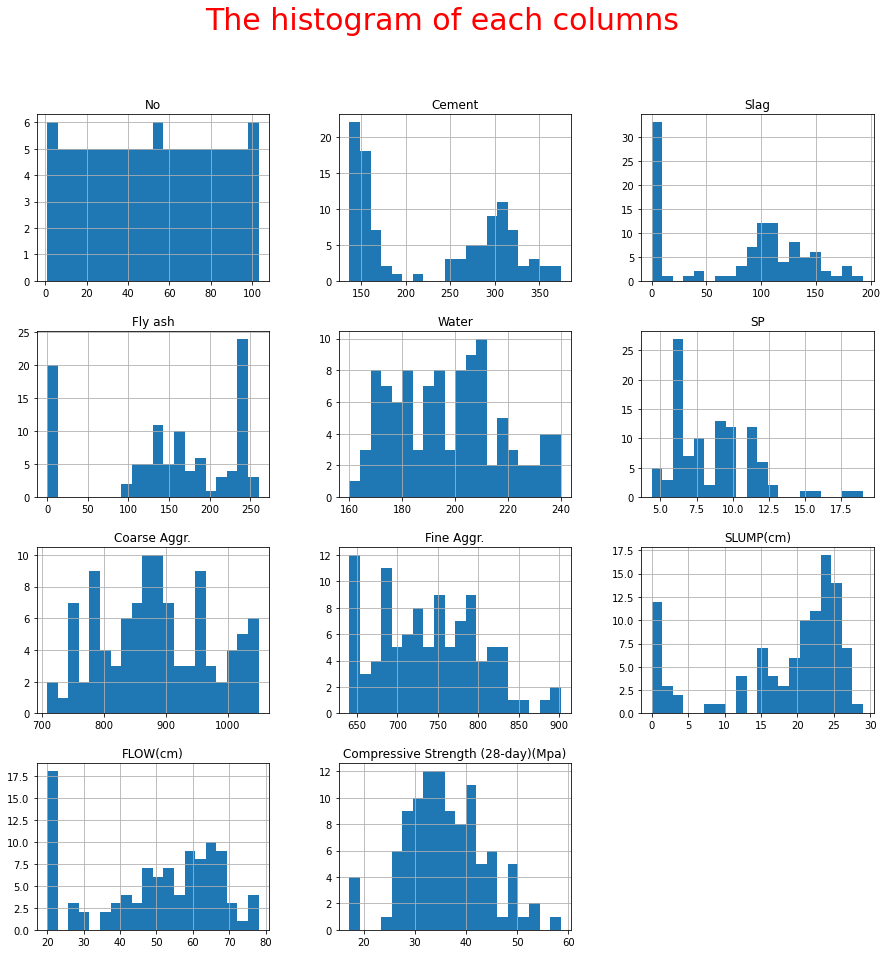

In [22]:
#plot the histogram of each column so as to display different features
df2.hist(bins=20, figsize=(15,15))
plt.suptitle("The histogram of each columns",fontsize=30, color = 'red')
plt.show()


In [23]:
#Check the datatype of each column
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   No                                  103 non-null    int64  
 1   Cement                              103 non-null    float64
 2   Slag                                103 non-null    float64
 3   Fly ash                             103 non-null    float64
 4   Water                               103 non-null    float64
 5   SP                                  103 non-null    float64
 6   Coarse Aggr.                        103 non-null    float64
 7   Fine Aggr.                          103 non-null    float64
 8   SLUMP(cm)                           103 non-null    float64
 9   FLOW(cm)                            103 non-null    float64
 10  Compressive Strength (28-day)(Mpa)  103 non-null    float64
dtypes: float64(10), int64(1)
memory usage: 9.0 KB

In [24]:
#Check if there is missing values
(df2 == np.nan).sum()

No                                    0
Cement                                0
Slag                                  0
Fly ash                               0
Water                                 0
SP                                    0
Coarse Aggr.                          0
Fine Aggr.                            0
SLUMP(cm)                             0
FLOW(cm)                              0
Compressive Strength (28-day)(Mpa)    0
dtype: int64

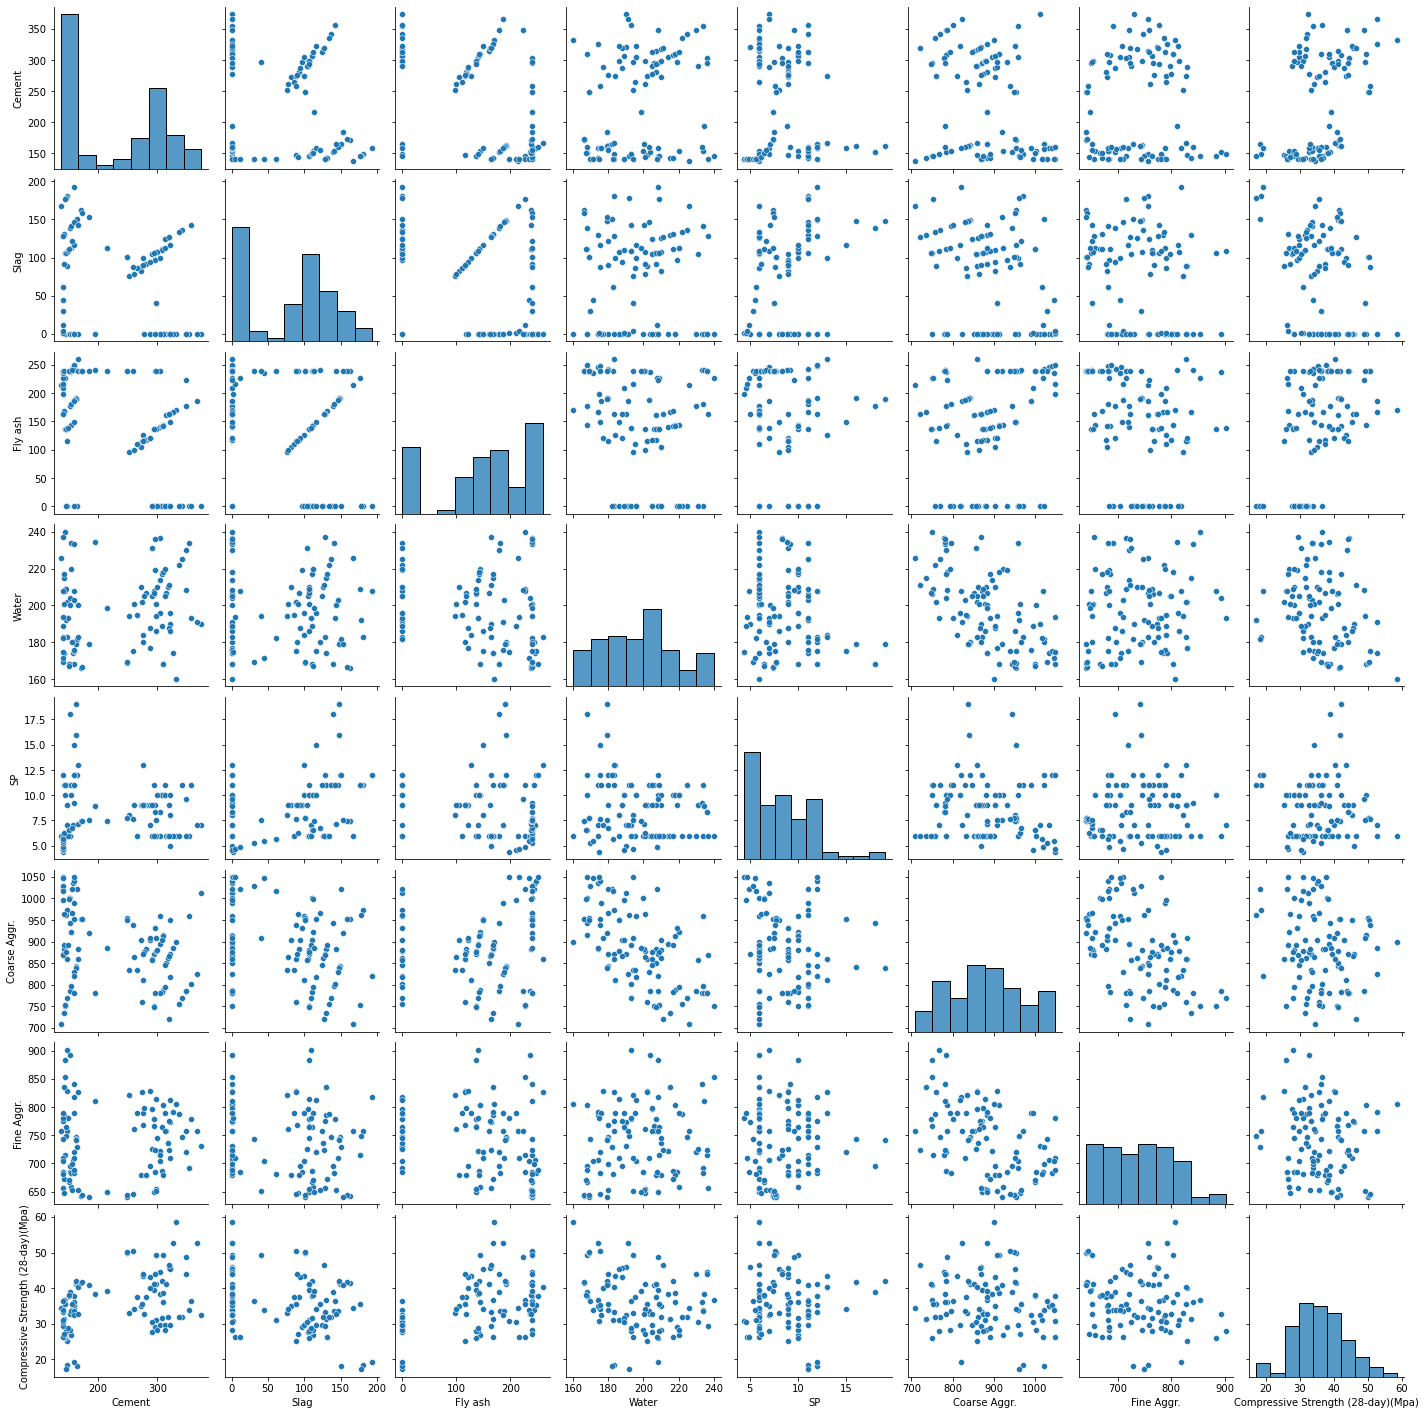

In [25]:
#Plot Scatter for each input and output pairs to see the correlation between each features and output
features = ["Cement", "Slag", "Fly ash", "Water", "SP", "Coarse Aggr.","Fine Aggr.","Compressive Strength (28-day)(Mpa)"]
sns.pairplot(df2[features])

#### 3.2.1 Data cleaning and transformation

In [26]:
# function  to form your feature matrix X and array y
#The first 7 column are used as input and the the last column as output
def clean(df):
    X_reg_unscaled = df.drop(labels=['No','SLUMP(cm)','FLOW(cm)', 'Compressive Strength (28-day)(Mpa)'], axis=1)
    y_reg = df["Compressive Strength (28-day)(Mpa)"]
    return (X_reg_unscaled, y_reg)

In [27]:
#generate unscaled input and output
X_reg_unscaled, y_reg = clean(df2)

In [28]:
#Using Standard Scaler to do scaling and generate scaled input
scaler = StandardScaler()
#Perform an appropriate feature scaling 
X_reg_scaled = scaler.fit_transform(X_reg_unscaled) 

### 3.3 Model Training and Parameter Tuning

In [29]:
#use MSE to measure the performance of the regression model
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# make a function to grid_search and fit all 3 regressors.
def grid_search(estimator, X, y, param_grid=[], scaled=False, scoring=mse_scorer):
    if scaled:
        scaled = GridSearchCV(estimator, param_grid, cv=3,scoring=scoring,return_train_score=True)
        scaled.fit(X, y)
        print(f"Scaled {estimator} fit!")
        return scaled
    else:
        raw = GridSearchCV(estimator, param_grid, cv=3,scoring=scoring,return_train_score=True)
        raw.fit(X, y)
        print(f"Uncaled {estimator} fit!")
        return raw

- For DecisionTreeRegressor the following hyperparameters are choosen:
1. criterion='mse' 
2. min_samples_leaf:The minimum number of samples a leaf node must have. Option(5,10,20)
3. max_features: should not greater than total features which is 7 in the project. Option(2,5,7)

- For DecisionTreeRegressor the following hyperparameters are choosen:
1. kernel:  The kernel of SVC are selected from sigmoid,poly and rbf.
2. C: A small C value leads to more margin violations and a big C leads to less margin violations. Option(5,10,20)
3. gamma: selected between scale and auto

In [30]:
#hyperparameter option for both DT Regressor
param_grid_dtr = [{
    'min_samples_leaf': [5, 10, 20],
    'max_features': [2,5,7],
    'criterion' :['mse']
}]
#hyperparameter option for both SVM Regressor
param_grid_svr = [{
    'kernel': ['poly', 'rbf', 'sigmoid'],
    'C': [5, 10, 20],
    'gamma': ['scale', 'auto']
}]

In [31]:
#Cross validation to find the best hyperparameters and fit the model for 3 regressor
dtr_unscaled = grid_search(DecisionTreeRegressor(criterion='mse'), X_reg_unscaled, y_reg,param_grid = param_grid_dtr, scaled=False)
dtr_scaled = grid_search(DecisionTreeRegressor(criterion='mse'), X_reg_scaled, y_reg,param_grid = param_grid_dtr,scaled=True)
svr_scaled = grid_search(SVR(), X_reg_scaled, y_reg,param_grid = param_grid_svr,scaled=True)

Uncaled DecisionTreeRegressor() fit!
Scaled DecisionTreeRegressor() fit!
Scaled SVR() fit!


### 3.4 Comparison and Conclusion


In [32]:
#define a function to print result of best parameter and MSE
def print_result(estimator,mse,name):
    '\033[1;31m' + 'Performanace of Stochastic Gradient Descent classifier ' + '\033[0m'
    print('\033[1;31m' + f"Model:{name}\033[0m\nBest Parameters: {estimator.best_params_}\nMSE:{mse}")

In [33]:
#define a function to plot illustration of prediction results
v

#### 3.4.1 DT Regressor (raw)

In [34]:
#Get the predict value and display the best hyperpareameter and MSE
dtr_unscaled_y_pre = dtr_unscaled.predict(X_reg_unscaled)
dtr_unscaled_mse = mean_squared_error(dtr_unscaled_y_pre,y_reg)
print_result(dtr_unscaled,dtr_unscaled_mse,'DT Regressor (raw)')

Model:DT Regressor (raw)
Best Parameters: {'criterion': 'mse', 'max_features': 7, 'min_samples_leaf': 5}
MSE:7.09413323817229


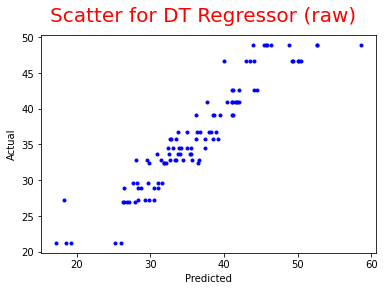

In [35]:
#Plot figure illustrating the prediction results for Scatter for DT Regressor (raw)
plot_figure(y_reg, dtr_unscaled_y_pre,"Scatter for DT Regressor (raw)")

#### 3.4.2 DT Regressor(scaled)


In [36]:
#Get the predict value and display the best hyperpareameter and MSE
dtr_scaled_y_pre = dtr_scaled.predict(X_reg_scaled)
dtr_scaled_mse = mean_squared_error(dtr_scaled_y_pre,y_reg)
print_result(dtr_scaled,dtr_scaled_mse,'DT Regressor(scaled)')

Model:DT Regressor(scaled)
Best Parameters: {'criterion': 'mse', 'max_features': 7, 'min_samples_leaf': 5}
MSE:7.09413323817229


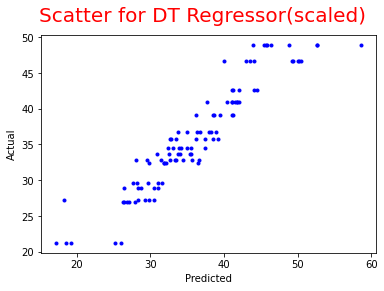

In [37]:
#Plot figure illustrating the prediction results for DT Regressor(scaled)
plot_figure(y_reg, dtr_scaled_y_pre,"Scatter for DT Regressor(scaled)")

#### 3.4.3 SVR(scaled)

In [38]:
#Get the predict value and display the best hyperpareameter and MSE
svr_scaled_y_pre = svr_scaled.predict(X_reg_scaled)
svr_scaled_mse = mean_squared_error(svr_scaled_y_pre,y_reg)
print_result(svr_scaled,svr_scaled_mse,'SVR(scaled)')

Model:SVR(scaled)
Best Parameters: {'C': 20, 'gamma': 'scale', 'kernel': 'rbf'}
MSE:0.14575939558691978


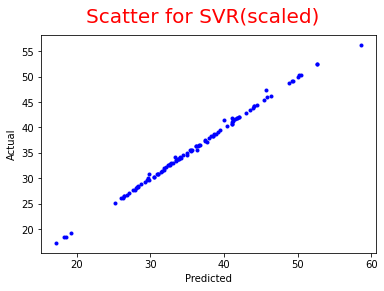

In [39]:
#Plot figure illustrating the prediction results for SVR(scaled)
plot_figure(y_reg, svr_scaled_y_pre,"Scatter for SVR(scaled)")

#### 3.4.4 Conclusion

1. For the choosing hyperparameters, both DT regressiors select the same values, but sometime not.
2. As long as choosing the same hyperparameter, both DT regressiors perform the same. They have same MSE and prediction/actual pattern. We can say that DT regressiors are not sensitive to scaling.
3. According to the MSE result and the scatter, SVR perform much more better than both DTs as long as DTs are not overfitting.

